<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-the-stocks" data-toc-modified-id="Loading-the-stocks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading the stocks</a></span></li><li><span><a href="#Getting-the-AI-started" data-toc-modified-id="Getting-the-AI-started-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting the AI started</a></span><ul class="toc-item"><li><span><a href="#Regression" data-toc-modified-id="Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Regression</a></span></li></ul></li></ul></div>

# AI Part

In [1]:
# cell for autoreload includes
%load_ext autoreload
%autoreload 2

## Loading the stocks

In [2]:
from src.stocks import Stocks
# The warnings are due to the includes in the file

22/06/15 12:32:44 WARN Utils: Your hostname, Mathieus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.25 instead (on interface en0)
22/06/15 12:32:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/15 12:32:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/06/15 12:32:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
from pyspark.sql.types import DoubleType, StringType, DateType, StructType, StructField

In [4]:
data_schema = StructType([
    StructField('Date', DateType(), True),
    StructField('High', DoubleType(), True),
    StructField('Low', DoubleType(), True),
    StructField('Open', DoubleType(), True),
    StructField('Close', DoubleType(), True),
    StructField('Volume', DoubleType(), True),
    StructField('Adj Close', DoubleType(), True),
    StructField('company_name', StringType(), True)
])

In [5]:
stocks = Stocks(header=True, delimiter=',', schema=data_schema)

In [6]:
stock = stocks.stocks[0]

In [9]:
stock.predict.load_insights()

## Getting the AI started

In [10]:
stock.predict.fullDF.show(4)

22/06/15 12:33:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/15 12:33:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+-----------------+------------------+------------------+---------------+-----------------+--------------------+----------------+
|      Date|             High|              Low|             Open|            Close|   Volume|        Adj Close|       next_Close|               CCI|               roc|       momentum|    R_de_williams|moving_average_Close|daily_return_day|
+----------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+-----------------+------------------+------------------+---------------+-----------------+--------------------+----------------+
|2017-01-04|791.3400268554688|783.1599731445312|788.3599853515625|786.9000244140625|1073000.0|786.9000244140625|  794.02001953125|133.33333333333334|1.0009667613293605| 0.760009765625|71.42862753723371|     786.52001953125|   -1.4599609375|
|2017-01-05|  794.47998046875|  785.

### Regression

In [24]:
from src.stock_prediction import StockPrediction

In [25]:
stock_pred = StockPrediction(stock)

In [29]:
pred = stock_pred.exe_linear_regression()

22/06/15 12:38:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/15 12:38:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/15 12:38:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/15 12:38:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/15 12:38:30 WARN Instrumentation: [1d9dada0] regParam is zero, which might cause numerical instability and overfitting.
22/06/15 12:38:30 WARN Instrumentation: [1d9dada0] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
22/06/15 12:38:30 WARN WindowExec: No Partition Defined for Window ope

In [30]:
vals = pred.select("next_Close", "pred_next_Close")

In [31]:
vals.show()

22/06/15 12:38:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/15 12:38:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----------------+-----------------+
|       next_Close|  pred_next_Close|
+-----------------+-----------------+
|806.6500244140625|807.5111728813874|
|807.8800048828125|805.8585293392962|
|806.0700073242188|805.8250421314674|
|835.6699829101562|825.3154410127559|
| 798.530029296875|795.1563702370511|
|808.3800048828125|810.0547310035308|
|824.1599731445312|822.8772497691152|
| 829.280029296875|829.9256349463228|
|845.5399780273438|845.6200279519994|
|845.6199951171875|850.2853161549829|
|847.2000122070312|848.4901827848453|
|852.1199951171875|851.3245599108761|
|830.4600219726562|850.0124941955137|
| 819.510009765625|815.5804573165135|
|831.4099731445312|835.0783005780647|
|837.1699829101562|825.8655198830729|
|           874.25|872.2317311320123|
|964.8599853515625|976.7142039824093|
| 939.780029296875|940.7887719095809|
|957.0900268554688|959.2876731577808|
+-----------------+-----------------+
only showing top 20 rows



In [32]:
import matplotlib.pyplot as plt 

22/06/15 12:38:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/15 12:38:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


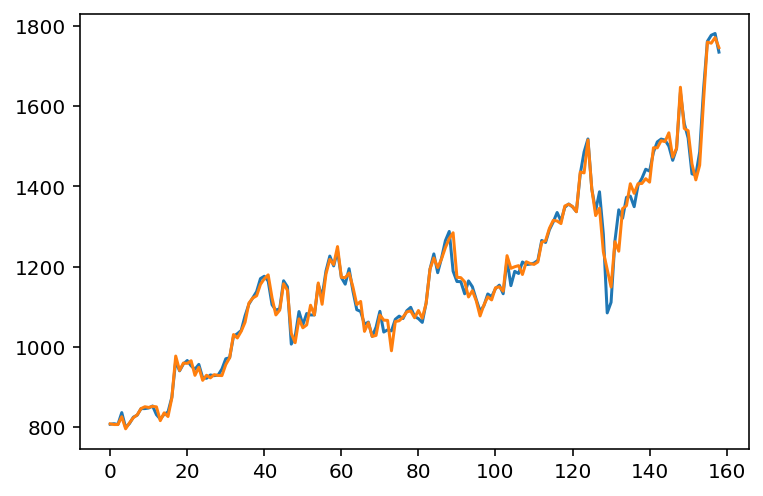

In [33]:
plt.plot(vals.toPandas())

22/06/15 12:38:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/15 12:38:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/15 12:38:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/15 12:38:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/15 12:38:41 WARN Instrumentation: [5bb73927] regParam is zero, which might cause numerical instability and overfitting.
22/06/15 12:38:41 WARN Instrumentation: [5bb73927] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
22/06/15 12:38:41 WARN WindowExec: No Partition Defined for Window ope

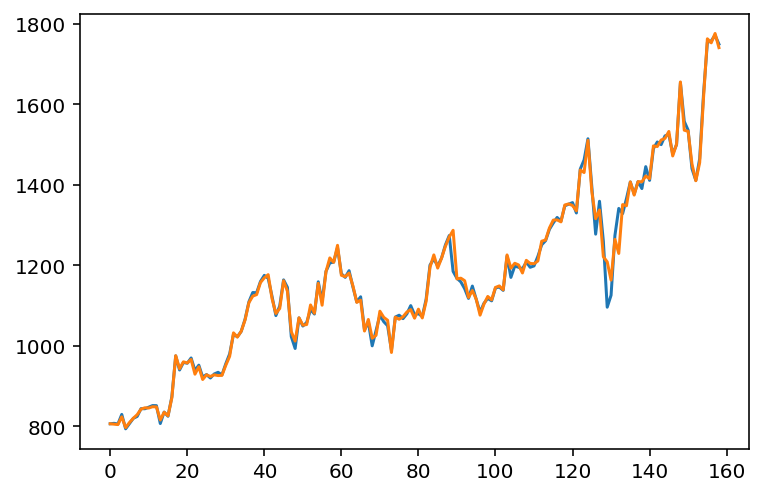

In [34]:
stock_pred.draw("Open")